In [3]:
import pandas as pd

multnomah_crash = pd.read_csv('Data/Multnomah.csv', low_memory=False)
multnomah_crash = multnomah_crash[multnomah_crash['Record Type'] == 1]
multnomah_crash.dropna(axis='columns', how='all', inplace=True)    
multnomah_crash.reset_index(inplace=True)
multnomah_crash.shape

(54208, 98)

In [5]:
# convert lon/lat degree-minute-second to decimal degrees
# use minus (-) sign because 'Longitude Degrees' is a negative number
multnomah_crash['Longitude Decimal'] = multnomah_crash['Longitude Degrees'] -\
                                       multnomah_crash['Longitude Minutes']/60 -\
                                       multnomah_crash['Longitude Seconds']/3600
multnomah_crash['Latitude Decimal'] = multnomah_crash['Latitude Degrees'] +\
                                      multnomah_crash['Latitude Minutes']/60 +\
                                      multnomah_crash['Latitude Seconds']/3600
# drop degree-minute-second columns
multnomah_crash.drop(columns=['Longitude Degrees', 'Longitude Minutes', 'Longitude Seconds',
                              'Latitude Degrees', 'Latitude Minutes', 'Latitude Seconds'], inplace=True)

In [15]:
# portland neighbourhood
from matplotlib.collections import PatchCollection
from descartes import PolygonPatch
import fiona
from shapely.geometry import Polygon, MultiPolygon, shape

%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

portland_shapefile = fiona.open("Data/External_data/Neighborhood_Boundaries/Neighborhood_Boundaries.shp")
county_shapefile = fiona.open("Data/External_data/County_Boundaries/County_Boundaries.shp")

In [18]:
# Filter Multnomah
mp_multnomah = MultiPolygon([shape(pol['geometry']) for pol in county_shapefile 
                          if pol['properties']['COUNTY'] == 'Multnomah'])
# Display Portland neighborhoods
mp_portland = MultiPolygon([shape(pol['geometry']) for pol in portland_shapefile])

<IPython.core.display.Javascript object>


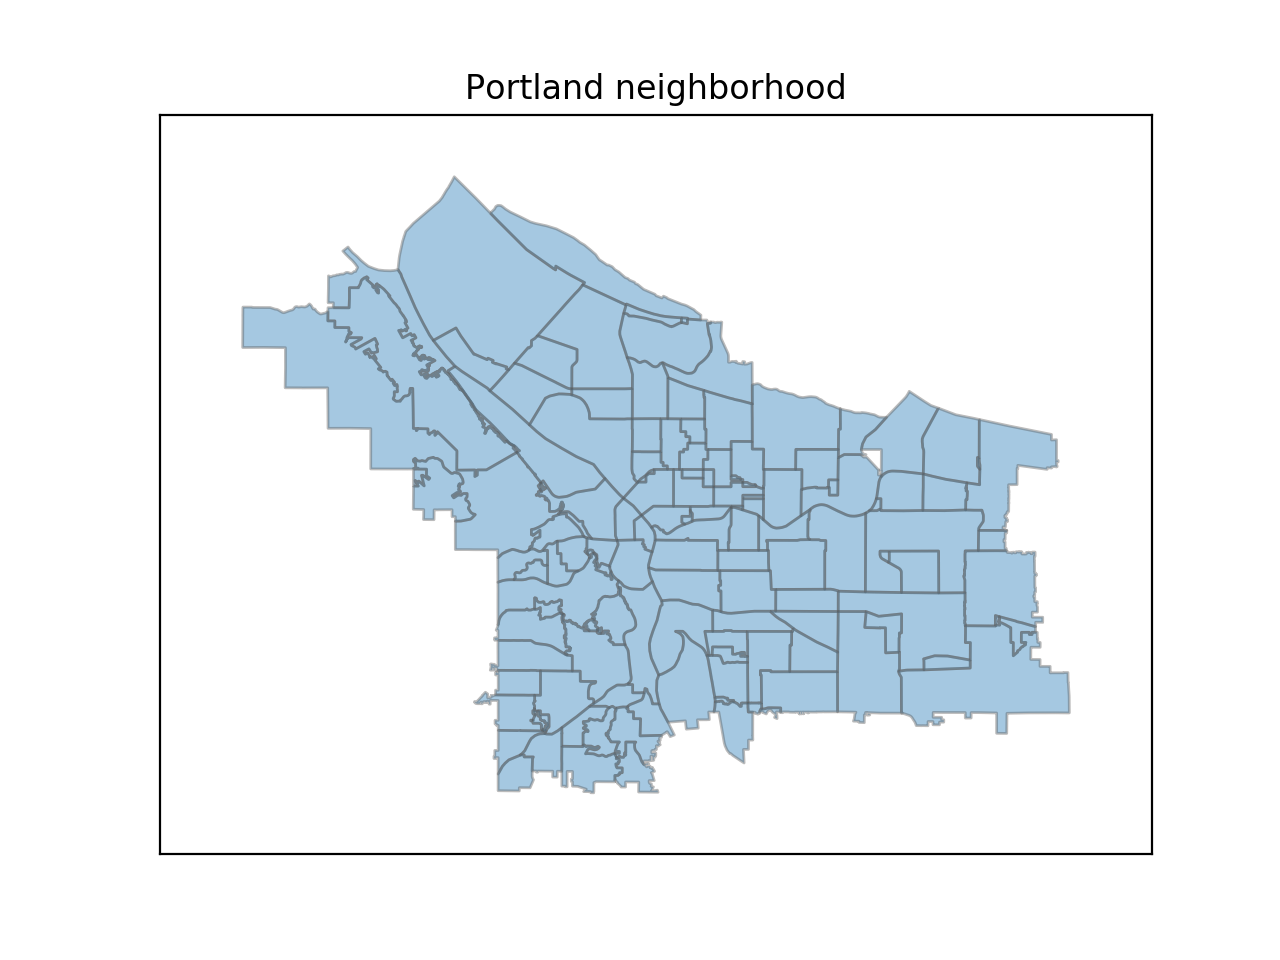

Text(0.5,1,'Portland neighborhood')

In [19]:
# Plot Multnomah county and Portland neighborhood
fig, ax = plt.subplots()
minx, miny, maxx, maxy = mp_portland.bounds
w, h = maxx - minx, maxy - miny
ax.set_xlim(minx - 0.1 * w, maxx + 0.1 * w)
ax.set_ylim(miny - 0.1 * h, maxy + 0.1 * h)

patches = []
for idx, p in enumerate(mp_portland):
    patches.append(PolygonPatch(p, ec='#555555', alpha=.4, zorder=1))
ax.add_collection(PatchCollection(patches, match_original=True))
ax.set_xticks([])
ax.set_yticks([])
plt.title("Portland neighborhood")

In [29]:
# Extract all longitude and latitude data only for experiment
lon_lat = multnomah_crash[['Longitude Decimal', 'Latitude Decimal', 'Crash Year']]
lon_lat.columns = ['Longitude', 'Latitude', 'Year']
# print(lon_lat.head())

import geopandas as gpd
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(lon_lat.Longitude, lon_lat.Latitude)]
# print(geopoints)

df = lon_lat.drop(['Longitude', 'Latitude'], axis=1)
crs = {'init': 'epsg:4326'}
accidents = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
# accidents.plot(color='#f46d43', markersize=1)

# out = r"Data/External_data/Multnomah_crash.shp"
# accidents.to_file(out)

<IPython.core.display.Javascript object>


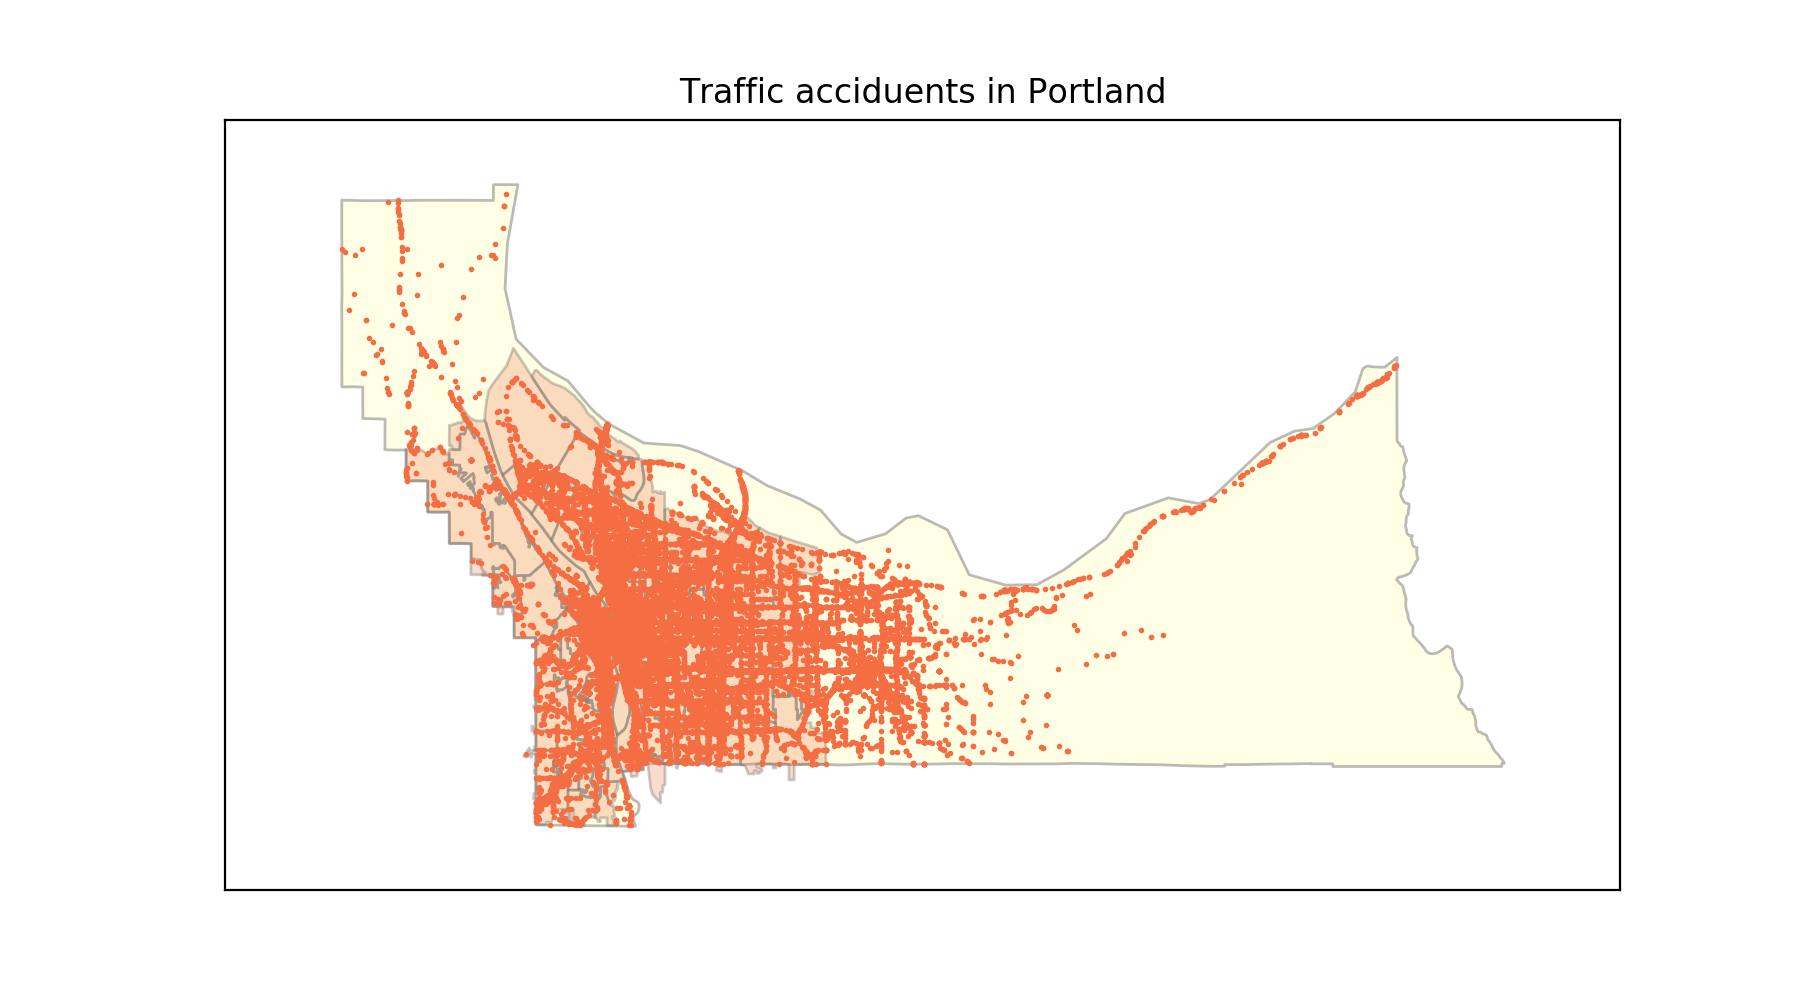

In [24]:
# Lay accidents points over the county layer
fig, ax = plt.subplots(figsize=(9, 5))
minx, miny, maxx, maxy = mp_multnomah.bounds
w, h = maxx - minx, maxy - miny
ax.set_xlim(minx - 0.1 * w, maxx + 0.1 * w)
ax.set_ylim(miny - 0.1 * h, maxy + 0.1 * h)

patches_multnomah = []
patches_portland = []
# County patches
for idx, p in enumerate(mp_multnomah):
    patches_multnomah.append(PolygonPatch(p, color='#ffffbf', ec='#555555', alpha=.4, zorder=2))
# Portland patches
for idx, p in enumerate(mp_portland):
    patches_portland.append(PolygonPatch(p, color='#ef8a62', ec='#555555', alpha=0.3, zorder=1))

ax.add_collection(PatchCollection(patches_multnomah, match_original=True))
ax.add_collection(PatchCollection(patches_portland, match_original=True))

ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Traffic acciduents in Portland")

accidents.plot(ax=ax, color='#f46d43', markersize=1)


In [30]:
# Load count data (analysis conducted in QGIS)
count_crash_portland = pd.read_csv('QGIS_analysis/Count_crash_portland.csv', low_memory=False)
count_crash_portland.head()

,OBJECTID,NAME,COMMPLAN,SHARED,COALIT,HORZ_VERT,Shape_Leng,MAPLABEL,NUMPOINTS
0,1,ST. JOHNS,NaN,NaN,NPNS,HORZ,32669.06308,St. Johns,623
1,2,HAYDEN ISLAND NEIGHBORHOOD NETWORK,NaN,NaN,NPNS,HORZ,27707.08342,Hayden Island Neighborhood Network,284
2,3,LINNTON,NaN,NaN,NWNW,HORZ,52741.71977,Linnton,190
3,4,FOREST PARK/LINNTON,NaN,Y,NWNW,HORZ,57723.63535,Forest Park/Linnton,80
4,5,KENTON,ALBINA,NaN,NPNS,VERT,19182.56561,Kenton,468


<IPython.core.display.Javascript object>


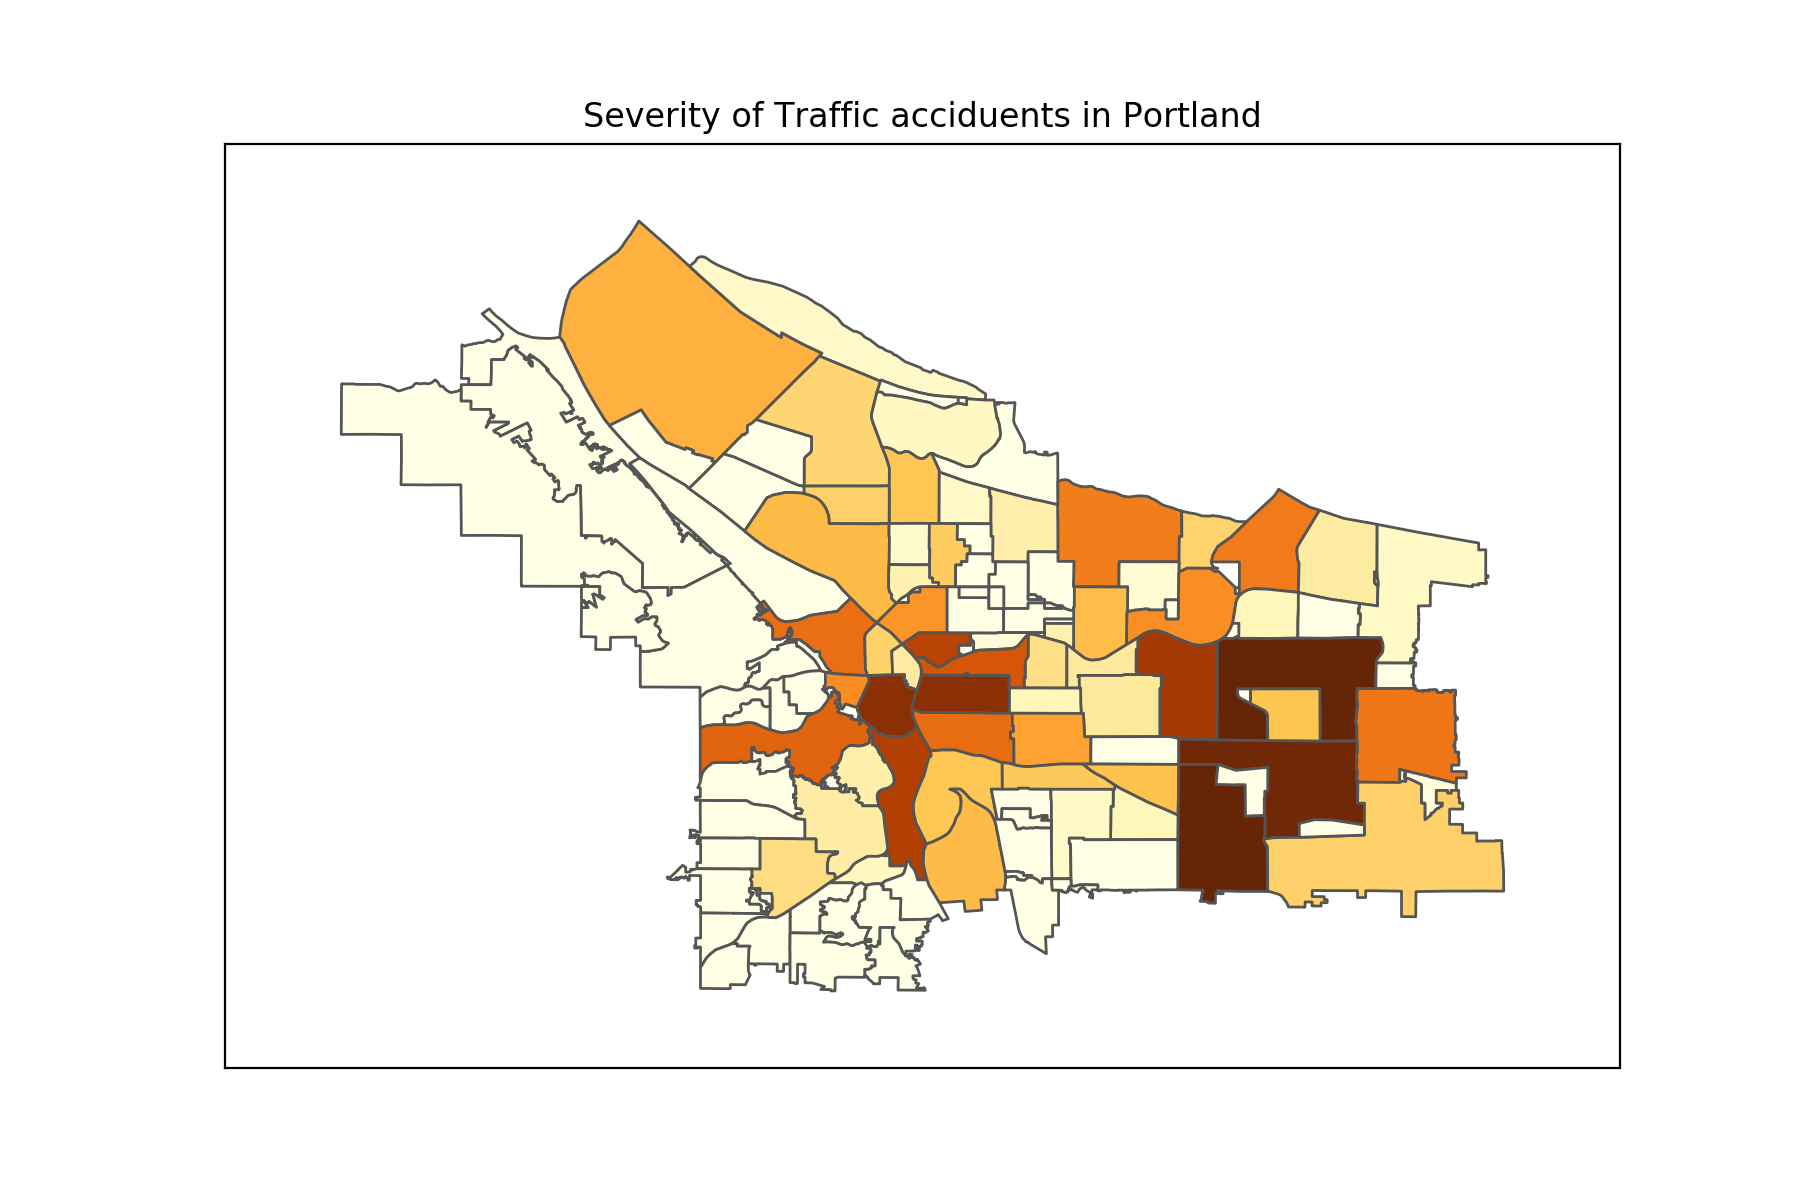

Text(0.5,1,'Severity of Traffic acciduents in Portland')

In [72]:
# Heat map of the Portland neighborhood
cm = plt.get_cmap('YlOrBr')
max_count = count_crash_portland['NUMPOINTS'].max()

# print(max_count)

fig, ax = plt.subplots(figsize=(9,6))
minx, miny, maxx, maxy = mp_portland.bounds
w, h = maxx - minx, maxy - miny
ax.set_xlim(minx - 0.1 * w, maxx + 0.1 * w)
ax.set_ylim(miny - 0.1 * h, maxy + 0.1 * h)

patches_multnomah = []
patches_portland = []
# # County patches
# for idx, p in enumerate(mp_multnomah):
#     patches_multnomah.append(PolygonPatch(p, color='#ffffbf', ec='#555555', alpha=.4, zorder=2))
# Portland patches
for idx, p in enumerate(mp_portland):
    colour = cm(1+np.log10(0.0001+count_crash_portland.iloc[idx]['NUMPOINTS'] / max_count))
    patches_portland.append(PolygonPatch(p, fc=colour, ec='#555555', alpha=1., zorder=1))

ax.add_collection(PatchCollection(patches_multnomah, match_original=True))
ax.add_collection(PatchCollection(patches_portland, match_original=True))

ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Severity of Traffic acciduents in Portland")
